In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, confusion_matrix
import time

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras import regularizers

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [0]:
filename = "test_gemini_BTCUSD_Close_2H_LWS3_IWS20_Trf['RP', 'GADF', 'MTF'].npz"

### Image window sizes

In [80]:
Image_window_size = np.int(filename[filename.find('_IWS') + 4 : filename.find("_Trf")])
Image_window_size

20

### Transformation types

In [81]:
Image_trf = eval(filename[filename.find('_Trf')+4:filename.find('.npz')])
Image_trf

['RP', 'GADF', 'MTF']

In [82]:
num_color_channels = len(Image_trf)
num_color_channels

3

#### In case file is missing run the data-check-and-prep with preferred settings and use the new file's name (cannot upload too big files to Git)

In [0]:
data = np.load('/content/drive/My Drive/Colab Notebooks/CNN/' + filename)

In [0]:
images = data['images']
image_labels = data['image_labels']
label_names = data['label_names']

# Check data

In [0]:
# for quick check: only 1000 images
# images = images[:1000]
# image_labels = image_labels[:1000]

In [86]:
images.shape

(12574, 20, 20, 3)

In [87]:
image_labels.shape

(12574, 3)

In [88]:
print("max: {}; min: {}".format(np.amax(images), np.amin(images)))

max: 1.0; min: 0.0


In [89]:
label_names = label_names.item()
label_names

{0: 'Buy', 1: 'Hold', 2: 'Sell'}

In [90]:
label_names_array = np.chararray(3, itemsize = 4).decode("utf-8")

for key, value in label_names.items():
  label_names_array[key] = value
label_names_array

array(['Buy', 'Hold', 'Sell'], dtype='<U4')

## e.g.:

Transformation type: RP


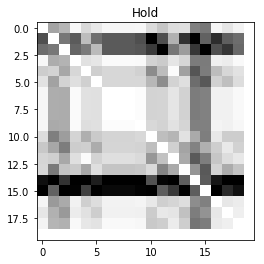

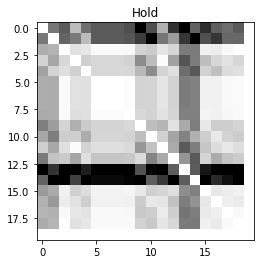

Transformation type: GADF


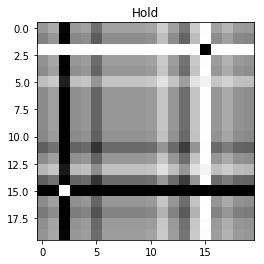

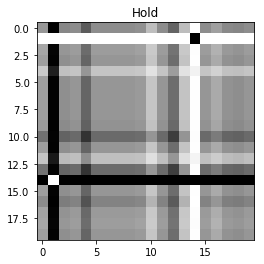

Transformation type: MTF


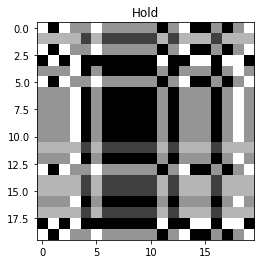

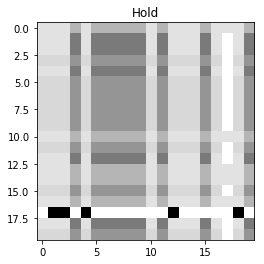

In [91]:
for trfidx, trf in enumerate(Image_trf):
    print('Transformation type: ' + trf)
    for idx, image in enumerate(images[:2,:,:, trfidx]):
        plt.imshow(image, cmap = "Greys")
        plt.title(label_names[np.int(np.argwhere(image_labels[idx]))])
        plt.show()

In [92]:
print("Images shape : {}; Labels shape : {}".format(images.shape, image_labels.shape))

Images shape : (12574, 20, 20, 3); Labels shape : (12574, 3)


# Train - test split without overlap
## We need to get rid of the first (Image Window Size -1) test data to avoid lookahead bias.

In [0]:
train_size = np.int(image_labels.shape[0]*.9)
images_train = images[:train_size, :]
images_test = images[(train_size+Image_window_size-1):]
image_labels_train = image_labels[:train_size, :]
image_labels_test = image_labels[(train_size+Image_window_size-1):]

In [94]:
print("Train images shape : {}; Train labels shape : {}".format(images_train.shape, image_labels_train.shape))

Train images shape : (11316, 20, 20, 3); Train labels shape : (11316, 3)


In [95]:
print("Test images shape : {}; Test labels shape : {}".format(images_test.shape, image_labels_test.shape))

Test images shape : (1239, 20, 20, 3); Test labels shape : (1239, 3)


# Baseline predictions
Choosing the biggest class to be the class of all

In [96]:
basepred = np.zeros(image_labels_test.shape)
basepred[:, np.argmax(np.sum(image_labels_test, 0))] = 1.0

base_acc = sum(np.equal(np.argmax(basepred, 1), np.argmax(image_labels_test, 1)))/np.sum(image_labels_test)
base_f1 = f1_score(y_true = image_labels_test, y_pred = basepred, average = 'macro')
# warning F1 due to only label 2 being predicted in baseline

print("Accuracy: {:.5f}".format(base_acc))

print("F1 score: {:.5f}".format(base_f1))

Accuracy: 0.42857
F1 score: 0.20000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# The Deep CNN

### Custom Keras Eval metrics: F1 Score

https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

In [0]:
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### Custom Time Logging

In [0]:
import keras.callbacks as keras_cb

class TimeHistory(keras_cb.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, epoch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

### Network Parameters

In [0]:
# image shape (d x d)
n_input = images_train.shape[1]
inputShape = (n_input, n_input, num_color_channels)

# number of classes
n_classes =  image_labels_train.shape[1]

# dropout
to_drop = 0.2 # prob. to DROP 

## Building the model

In [0]:
def createModel(input_shape, dropout = .2):
    model = Sequential()
    # Input
    model.add(Conv2D(32, 
                     (3, 3), 
                     padding='same', 
                     activation='relu', 
                     input_shape=input_shape))
    
    # Convolutions, pooling
    # model.add(Conv2D(32, 
    #                  (3, 3),
    #                  padding='same',
    #                  activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
  
    model.add(Conv2D(64, (3, 3), 
                     padding='same', 
                     activation='relu', 
                     kernel_regularizer=regularizers.l2(0.001)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
  
    # model.add(Conv2D(128, (3, 3), 
    #                  padding='same', 
    #                  activation='relu', 
    #                  kernel_regularizer=regularizers.l2(0.001)
    #                 ))
    
    # model.add(MaxPooling2D(pool_size=(2, 2)))
      
    # Flatten & Dense layers 
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dropout(.2))
    model.add(Dense(n_classes, activation='softmax'))
  
    return model

In [0]:
model1 = createModel(dropout = to_drop, input_shape = inputShape)

## Hyperparameter settings

In [0]:
training_iters = 100
batch_size = 128

### Accounting for imbalance

In [103]:
label_names

{0: 'Buy', 1: 'Hold', 2: 'Sell'}

In [104]:
np.sum(image_labels, axis = 0)/np.sum(image_labels)

array([0.26093526, 0.48425322, 0.25481152])

In [105]:
y_ints = [y.argmax() for y in image_labels_train]
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.2917808219178082, 1: 0.6796396396396397, 2: 1.3253689388615602}

## Compiling

In [0]:
model1.compile(optimizer='adam',
               loss='categorical_crossentropy', 
               metrics=['accuracy', f1])


## Training

In [107]:
history = model1.fit(images_train, 
                     image_labels_train, 
                     batch_size=batch_size, 
                     epochs=training_iters, verbose=1,
                     validation_data=(images_test, image_labels_test),
                     class_weight=class_weight_dict,
                     callbacks=[time_callback]
                    )
  
model1.evaluate(images_test, image_labels_test)

Train on 11316 samples, validate on 1239 samples
Epoch 1/100
11316/11316 [==============================] - 33s 3ms/step - loss: 1.0880 - acc: 0.4523 - f1: 0.2233 - val_loss: 0.9686 - val_acc: 0.5311 - val_f1: 0.4035
Epoch 2/100
11316/11316 [==============================] - 31s 3ms/step - loss: 0.9013 - acc: 0.4753 - f1: 0.3845 - val_loss: 0.8981 - val_acc: 0.5287 - val_f1: 0.4237
Epoch 3/100
11316/11316 [==============================] - 32s 3ms/step - loss: 0.8704 - acc: 0.4677 - f1: 0.3962 - val_loss: 0.8707 - val_acc: 0.5424 - val_f1: 0.4355
Epoch 4/100
11316/11316 [==============================] - 31s 3ms/step - loss: 0.8464 - acc: 0.4718 - f1: 0.3994 - val_loss: 0.8556 - val_acc: 0.5303 - val_f1: 0.4261
Epoch 5/100
11316/11316 [==============================] - 32s 3ms/step - loss: 0.8407 - acc: 0.4699 - f1: 0.3993 - val_loss: 0.8618 - val_acc: 0.5278 - val_f1: 0.4399
Epoch 6/100
11316/11316 [==============================] - 32s 3ms/step - loss: 0.8265 - acc: 0.4740 - f1: 0.40

KeyboardInterrupt: ignored

## Loss & Accuracy Curves

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# F1 Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['f1'],'r',linewidth=3.0)
plt.plot(history.history['val_f1'],'b',linewidth=3.0)
plt.legend(['Training F1 score', 'Validation F1 score'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1 Score',fontsize=16)
plt.title('F1 Curves',fontsize=16)

## Confusion Matrix

In [0]:
image_labels_pred = model1.predict(images_test)
image_labels_pred = np.where(image_labels_pred > 0.5, 1, 0)
cm =  pd.DataFrame(confusion_matrix(np.argmax(image_labels_test,1), np.argmax(image_labels_pred,1)), 
                                 index = label_names_array, 
                                 columns = label_names_array)

plt.figure(figsize=[8,6])
sn.heatmap(cm, annot=True,cmap='Blues', fmt='g')

## Time spent

In [0]:
print("Time spent on entire model training: {:4f} seconds".format(sum(time_callback.times)))